In [1]:
# Generic libraries
import math
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse as sparse
import Bio
import tqdm
import seaborn as sns
from itertools import product
import inspect
import multiprocessing
import time
import os
from pathlib import Path
import glob
#import ipympl
from scipy.ndimage.filters import uniform_filter1d

#from ipywidgets import *
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mtick
from collections import namedtuple
from tabulate import tabulate
from IPython.display import Latex
from IPython.display import HTML
from IPython.core.pylabtools import figsize
from matplotlib import rc


In [2]:
# shorthand to concatenate arrays
def cat(*a):
    return np.concatenate(np.array(a))

In [3]:
## plot settings
#plt.style.use('seaborn-deep')
heat_cmap = 'viridis'
matplotlib.rcParams["axes.formatter.useoffset"] = False

In [4]:
import MDAnalysis as mda
from pyfferaph import pyfferaph as pf
from pyfferaph import filter_pyff as pyff

## Import universe files

simdir = Path('../../data/00-external/')
TOP = simdir / '5Y36_hydrogen.top'
GRO = simdir / '5Y36_box.gro'
trajdir = '../../data/04-prod/'
TPR = trajdir + 'cas9_prod0_pyff.tpr' # use convert-tpr to delete the solvent from the tpr topology
XTC = trajdir + 'cas9_prod_pbc_205cut.xtc' # we use only the equilibrated part of the trajectory
u = mda.Universe(str(TPR), str(XTC))

simdir = Path('../../data/00-external_nodna/')
GRO = simdir / '5Y36_nodna_box.gro'
trajdir = '../../data/04-prod_nodna/'
TPR = trajdir + 'cas9_prod0_pyff.tpr' # use convert-tpr to delete the solvent from the tpr topology
XTC = trajdir + 'cas9_prod_pbc_250cut.xtc' # we use only the equilibrated part of the trajectory
u_n = mda.Universe(str(TPR), str(XTC))


In [5]:
# set paths for output
plotpath = "../../plots/"
datapath = "../../data/analysis/pyinteraph/"

output_name = "prod_"
output_name_n = "prod_nodna_"

sb_file = datapath+output_name+'sbridges.dat'
hc_file = datapath+output_name+'hydrophobic.dat'
hb_file = datapath+output_name+'hbonds.dat'

sb_file_n = datapath+output_name_n+'sbridges.dat'
hc_file_n = datapath+output_name_n+'hydrophobic.dat'
hb_file_n = datapath+output_name_n+'hbonds.dat'


In [6]:
sb_matrix = np.loadtxt(sb_file)
hc_matrix = np.loadtxt(hc_file)
hb_matrix = np.loadtxt(hb_file)
# matrix with the combined interactions
reduced_matrix = np.amax([sb_matrix, hc_matrix, hb_matrix], axis=0)
type_matrix = np.argmax([np.zeros(np.shape(sb_matrix)), sb_matrix, hc_matrix, hb_matrix], axis=0)

In [7]:
sb_matrix_n = np.loadtxt(sb_file_n)
hc_matrix_n = np.loadtxt(hc_file_n)
hb_matrix_n = np.loadtxt(hb_file_n)
# matrix with the combined interactions
reduced_matrix_n = np.amax([sb_matrix_n, hc_matrix_n, hb_matrix_n], axis=0)
type_matrix_n = np.argmax([np.zeros(np.shape(sb_matrix_n)), sb_matrix_n, hc_matrix_n, hb_matrix_n], axis=0)

In [8]:
# create an array with the residue names
resnames = [u.select_atoms('resid ' + str(i)).resnames[1] for i in range(0,len(sb_matrix))]
resnames_n = [u_n.select_atoms('resid ' + str(i)).resnames[1] for i in range(0,len(sb_matrix_n))]

# create an array with the 1-letter aminoacid names
d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M',
    'HID': 'H', 'HIE': 'H', 'HIP': 'H', 'LYN': 'K', 'GLH': 'E',
    'G': 'G', 'T': 'T', 'A': 'A', 'C': 'C', 'U': 'U', 'DG': 'G',
     'DC': 'C', 'DA': 'A', 'DT': 'T', 'RG': 'G', 'RG5': 'G','RC': 'C',
     'RU': 'U', 'RU3': 'U', 'RA': 'A'}

rnames = np.array([d3to1[resnames[i]] for i in range(0,len(sb_matrix))])
rnames_n = np.array([d3to1[resnames_n[i]] for i in range(0,len(sb_matrix_n))])

rows = [rnames[i]+str(i) for i in range(0,len(rnames))]
rows_n = [rnames_n[i]+str(i) for i in range(0,len(rnames_n))]


In [134]:
df_all = pd.DataFrame(reduced_matrix, index=rows, columns=rows)
df_all_n = pd.DataFrame(reduced_matrix_n, index=rows_n, columns=rows_n)

df_type = pd.DataFrame(type_matrix, index=rows, columns=rows)
df_type_n = pd.DataFrame(type_matrix_n, index=rows_n, columns=rows_n)
# filter the type of interactions matrix to include only interactions with a certain persistence
pers_cutoff = 80
df_type_cut = df_type.loc[(abs(df_all) > pers_cutoff).any(axis=1)]
df_type_cut = df_type_cut.loc[:,(abs(df_all) > pers_cutoff).any(axis=0)]
df_type_cut_n = df_type_n.loc[(abs(df_all_n) > pers_cutoff).any(axis=1)]
df_type_cut_n = df_type_cut_n.loc[:,(abs(df_all_n) > pers_cutoff).any(axis=0)]

# difference in persistence between the two system's residues
df_diff = df_all_n.iloc[0:len(df_all_n)-1,0:len(df_all_n)-1] - df_all.iloc[0:len(df_all_n)-1,0:len(df_all_n)-1]
print(len(df_all), len(df_all_n), len(df_diff), len(df_type_cut), len(df_type_cut_n))


1549 1467 1466 600 524


<IPython.core.display.Javascript object>


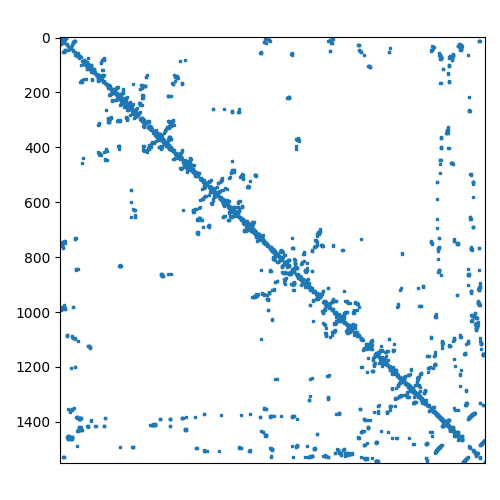

In [58]:
fig, ax = plt.subplots(figsize = (5, 5))
plt.spy(df_all, precision=10, markersize=2)

ax.tick_params(left=True, top=False)
ax.axes.get_xaxis().set_ticks([])

fig.savefig(plotpath+"spyplot.pdf")

<IPython.core.display.Javascript object>


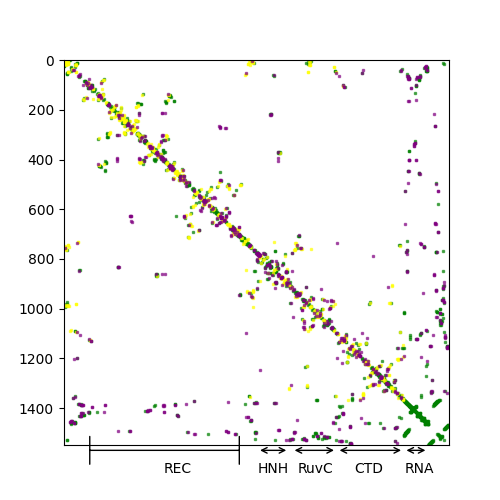

/home/kryohi/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7837: RuntimeWarning: invalid value encountered in greater
  nonzero = np.abs(Z) > precision
/home/kryohi/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7837: RuntimeWarning: invalid value encountered in greater
  nonzero = np.abs(Z) > precision
/home/kryohi/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7837: RuntimeWarning: invalid value encountered in greater
  nonzero = np.abs(Z) > precision


In [55]:
fig, ax = plt.subplots(figsize = (5, 5))
cutoff = 20
df_type_sel = df_type_all[(df_all > cutoff)]
ax.spy(df_type_sel[(df_type_all == 3)], markersize=2, color='green', label='Hbonds', alpha=0.6)
ax.spy(df_type_sel[(df_type_all == 2)], markersize=2, color='yellow', alpha=0.6)
ax.spy(df_type_sel[(df_type_all == 1)], markersize=2, color='purple', alpha=0.6)

ax.tick_params(left=True, top=False)
ax.axes.get_xaxis().set_ticks([])

arrowypos = 1570
textypos = 1660

ax.annotate('', xy=(93, arrowypos), xytext=(717,arrowypos),     #draws an arrow from set of coordinates to the other
            arrowprops=dict(arrowstyle='|-|',facecolor='red'),
            annotation_clip=False)                              #This enables the arrow to be outside of the plot

ax.annotate('REC',xy=(400,textypos),xytext=(400,textypos), annotation_clip=False) # adds text label

ax.annotate('', xy=(778, arrowypos), xytext=(906,arrowypos),               
            arrowprops=dict(arrowstyle='<->',facecolor='red'), annotation_clip=False)                              
ax.annotate('HNH',xy=(780,textypos), xytext=(780,textypos), annotation_clip=False)

ax.annotate('', xy=(1098, arrowypos),xytext=(1368,arrowypos),             
            arrowprops=dict(arrowstyle='<->',facecolor='red'), annotation_clip=False)
ax.annotate('CTD',xy=(1170,textypos),xytext=(1170,textypos), annotation_clip=False)

ax.annotate('', xy=(1367, arrowypos),xytext=(1466,arrowypos),             
            arrowprops=dict(arrowstyle='<->',facecolor='red'), annotation_clip=False)
ax.annotate('RNA',xy=(1370,textypos),xytext=(1370,textypos), annotation_clip=False)

ax.annotate('', xy=(917, arrowypos), xytext=(1098,arrowypos),               
            arrowprops=dict(arrowstyle='<->',facecolor='red'), annotation_clip=False)                              
ax.annotate('RuvC',xy=(940,textypos),xytext=(940,textypos), annotation_clip=False)

ax.figure.savefig(plotpath+"spyplot_type.pdf")

<IPython.core.display.Javascript object>


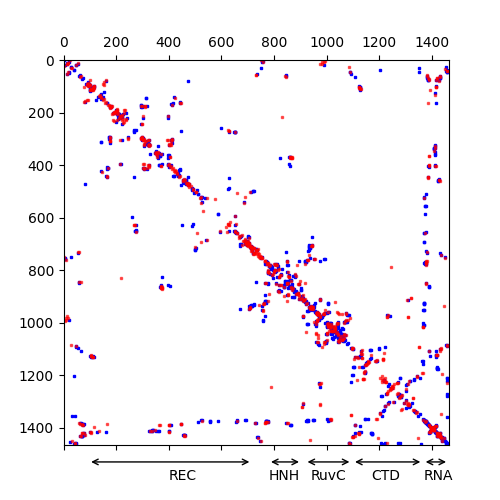

/home/kryohi/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7837: RuntimeWarning: invalid value encountered in greater
  nonzero = np.abs(Z) > precision
/home/kryohi/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7837: RuntimeWarning: invalid value encountered in greater
  nonzero = np.abs(Z) > precision


In [13]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.spy(df_diff[(df_diff > 0)], precision=20, markersize=2, color='blue')
ax.spy(df_diff[(df_diff < 0)], precision=20, markersize=2, color='red', alpha=0.6)

arrowypos = 1530
textypos = 1600

ax.tick_params(left=True, top=False)
ax.axes.get_xaxis().set_ticks([])


ax.annotate('', xy=(93, arrowypos), xytext=(717,arrowypos),     #draws an arrow from set of coordinates to the other
            arrowprops=dict(arrowstyle='<->',facecolor='red'),  #sets style of arrow and colour
            annotation_clip=False)                              #This enables the arrow to be outside of the plot

ax.annotate('REC',xy=(400,textypos),xytext=(400,textypos), annotation_clip=False) # adds text label

ax.annotate('', xy=(778, arrowypos), xytext=(906,arrowypos),               
            arrowprops=dict(arrowstyle='<->',facecolor='red'), annotation_clip=False)                              
ax.annotate('HNH',xy=(780,textypos), xytext=(780,textypos), annotation_clip=False)

ax.annotate('', xy=(1098, arrowypos),xytext=(1368,arrowypos),             
            arrowprops=dict(arrowstyle='<->',facecolor='red'), annotation_clip=False)
ax.annotate('CTD',xy=(1170,textypos),xytext=(1170,textypos), annotation_clip=False)

ax.annotate('', xy=(1367, arrowypos),xytext=(1466,arrowypos),             
            arrowprops=dict(arrowstyle='<->',facecolor='red'), annotation_clip=False)
ax.annotate('RNA',xy=(1370,textypos),xytext=(1370,textypos), annotation_clip=False)

ax.annotate('', xy=(917, arrowypos), xytext=(1098,arrowypos),               
            arrowprops=dict(arrowstyle='<->',facecolor='red'), annotation_clip=False)                              
ax.annotate('RuvC',xy=(940,textypos),xytext=(940,textypos), annotation_clip=False)

ax.figure.savefig(plotpath+"spyplot_comparison.pdf")

In [ ]:
#canvas, ax = plt.subplots(figsize = (11, 7))
#sns.heatmap(reduced_matrix[0:1467,0:1467]-reduced_matrix_n,
#            square=False, ax=ax, cbar=True, center=0, cmap='seismic')


### Matrices of contacts between different protein domains

In [16]:
# Domain definitions
HNH = 'protein and resid 779 to 905'
RUVC = 'protein and resid 1 to 55 or resid 717 to 764 or resid 917 to 1098'
CTD = 'protein and resid 1098 to 1367'
REC = 'protein and resid 93 to 717'
RNA = 'nucleic and resid 1368 to 1466'
DNA = 'nucleic and resid 1467 to 1548'
MG = 'name MG and resid 1549 1550' 
MG_n = 'name MG and resid 1467 1468'

HNH_idxs = np.r_[779:905]
RUVC_idxs = np.concatenate([np.arange(1,55),np.arange(717,764),np.arange(917,1098)])
CTD_idxs = np.arange(1098,1367)
REC_idxs = np.arange(93,717)
RNA_idxs = np.arange(1368,1466)
DNA_idxs = np.arange(1467,1548)
MG_idxs = np.arange(1549,1550)
MG_n_idxs = np.arange(1467,1468)

# converts domain names to the corresponding indexes
name2domain = {'HNH': HNH_idxs, 'RUVC': RUVC_idxs, 'CTD': CTD_idxs, 'REC': REC_idxs,
              'RNA': RNA_idxs, 'DNA': DNA_idxs, 'MG': MG_idxs, 'MG_n': MG_n_idxs}


In [150]:
def interactionsHeatmap(df, d1, d2, df_type=pd.DataFrame(), t='auto', filt='xy', filt_cutoff=0,
                        cmap='rocket', fname='contact_heatmap', figsize=(7.5,7), fullMatrix=False):
    """ TODO write docstring """
    
    
    ## Filter DataFrame df for the relevant domains
    df_small = df.iloc[name2domain[d1], name2domain[d2]]
    
    if fullMatrix: # plot the intradomain interactions as well
        domains = np.concatenate([name2domain[d1], name2domain[d2]])
        df_small = df.iloc[domains, domains]

    ## Choose the type of heatmap to use
    if t == 'auto':
        if np.min(np.min(df)) < 0:
            t = 'diff'
        elif not df_type.empty: #np.max(np.max(df)) == 3:
            t = 'typeOfInteraction'
            df_type_small = df_type.iloc[name2domain[d1], name2domain[d2]]
        else:
            t = 'standard'        
    
    ## Filter the interactions with a minimum value of persistence
    if filt=='xy':
        filtered_df_y = df_small.loc[(abs(df_small) > filt_cutoff).any(axis=1)]
        filtered_df = filtered_df_y.loc[:,(abs(filtered_df_y) > filt_cutoff).any(axis=0)]
        if t == 'typeOfInteraction':
            filtered_df_type = df_type_small.loc[(abs(df_small) > filt_cutoff).any(axis=1)]
            filtered_df_type = filtered_df_type.loc[:,(abs(filtered_df_y) > filt_cutoff).any(axis=0)]
            
    elif filt=='y':
        filtered_df = df_small.loc[(abs(df_small) > filt_cutoff).any(axis=1)]
        if t == 'typeOfInteraction':
            filtered_df_type = df_type_small.loc[(abs(df_small) > filt_cutoff).any(axis=1)]
            
    else:
        filtered_df = df_small
        if t == 'typeOfInteraction':
            filtered_df_type = df_type_small
    
    print('Shape of the matrix: ', np.shape(df_small), ' -> ', np.shape(filtered_df))
    
    ## Plot the heatmap of the interactions
    canvas, ax = plt.subplots(figsize = figsize)
    
    square = np.shape(filtered_df)[0]==np.shape(filtered_df)[1]

    if t == 'diff':
        cmap = 'seismic_r'
        sns.heatmap(filtered_df, square=square, ax=ax, cbar=True, center=0, cmap=cmap)
        ax.set_title('Persistence difference', fontsize=18, pad=20)
        
    elif t == 'typeOfInteraction':
        myColors = ((0.0, 0.0, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
        cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
        sns.heatmap(filtered_df_type, square=square, ax=ax, cbar=True, cmap=cmap)
        # Manually specify colorbar labelling after it's been generated
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([0.4, 1.1, 1.9, 2.5])
        colorbar.set_ticklabels(['None', 'SB', 'HC', 'HB'])
        ax.set_title('Type of non-covalent interaction', fontsize=18, pad=20)
        
    else:
        sns.heatmap(filtered_df, square=square, ax=ax, cbar=True, cmap=cmap)
        ax.set_title('Contact map', fontsize=18, pad=20)

    # X - Y axis labels
    ax.set_xlabel(d2, fontsize=16)
    ax.set_ylabel(d1, fontsize=16)
    
    #fig.tight_layout()
    
    ## Save and show the plot
    ax.figure.savefig(plotpath + fname + "_" + d1 + "_" + d2 + ".pdf", bbox_inches='tight')
    plt.show()
    

In [136]:
df_type.empty


False

(367, 367)  ->  (367, 367)


<IPython.core.display.Javascript object>


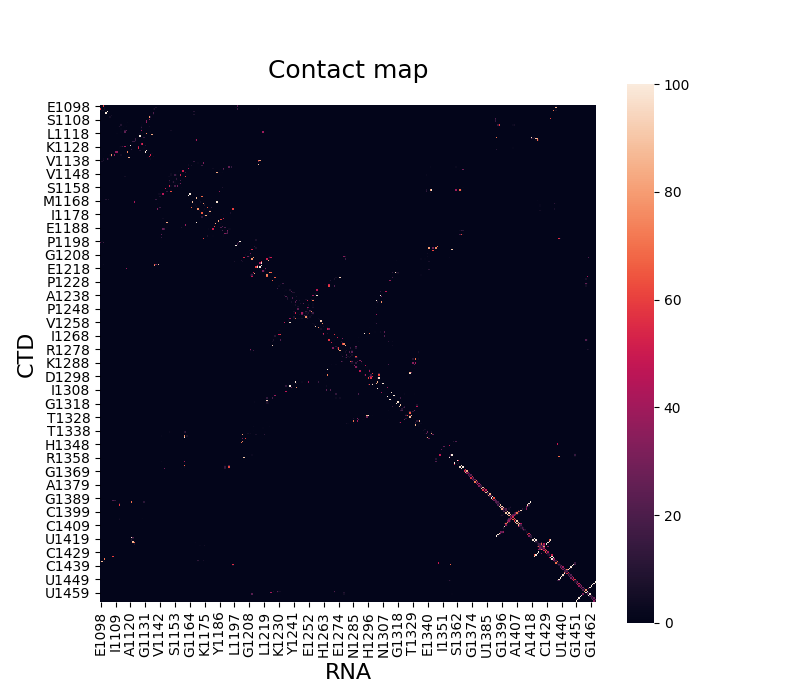

In [156]:
interactionsHeatmap(df_all, 'CTD', 'RNA', filt='None', fullMatrix=True, figsize=(8,7))

(269, 98)  ->  (19, 17)


<IPython.core.display.Javascript object>


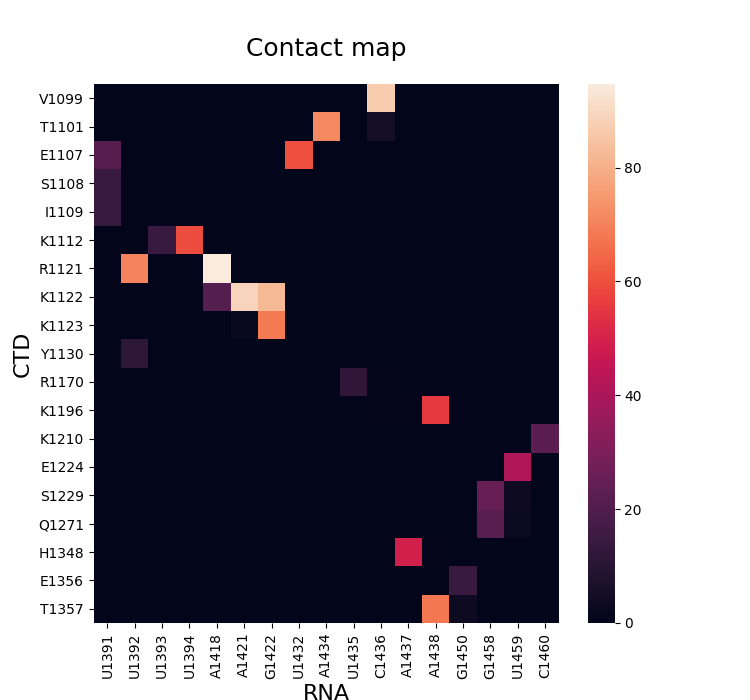

In [154]:
## now excluding the intradomain interactions
interactionsHeatmap(df_all, 'CTD', 'RNA', filt='xy', filt_cutoff=10)

(269, 98)  ->  (24, 20)


<IPython.core.display.Javascript object>


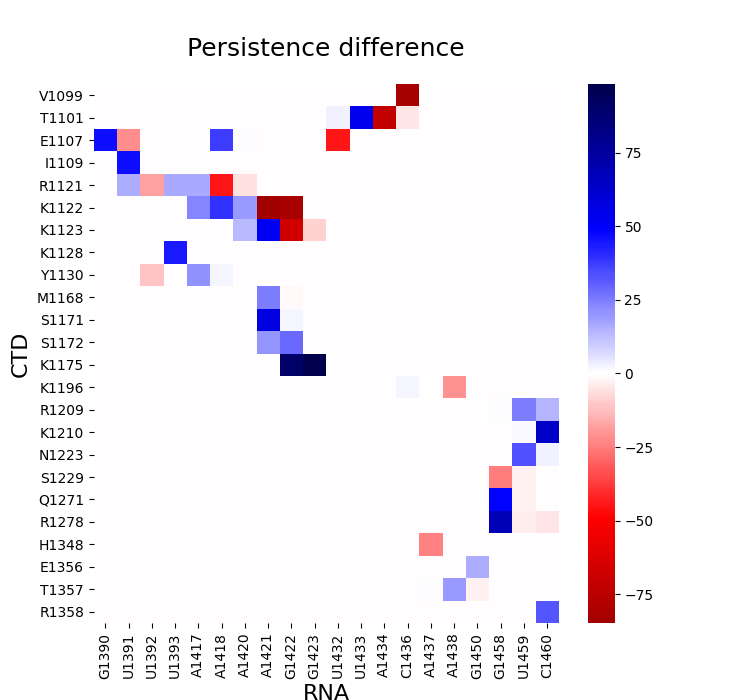

In [145]:
# difference in persistence between the system with and without DNA
interactionsHeatmap(df_diff, 'CTD', 'RNA', filt='xy', filt_cutoff=15, t='auto')

(269, 81)  ->  (22, 22)


<IPython.core.display.Javascript object>


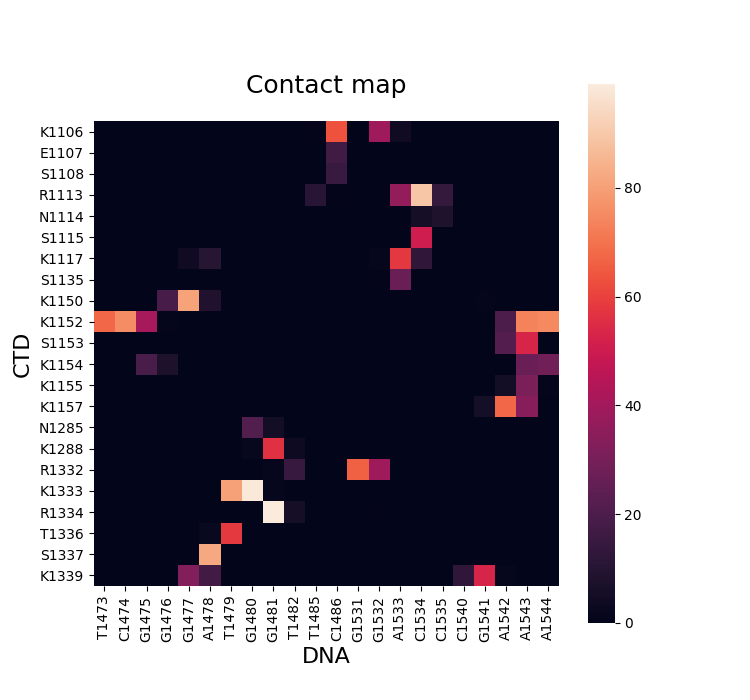

In [146]:
#G1480 e G1481 PAM sequence
interactionsHeatmap(df_all, 'CTD', 'DNA', filt='xy', filt_cutoff=5, t='auto')

(269, 81)  ->  (22, 22)


<IPython.core.display.Javascript object>


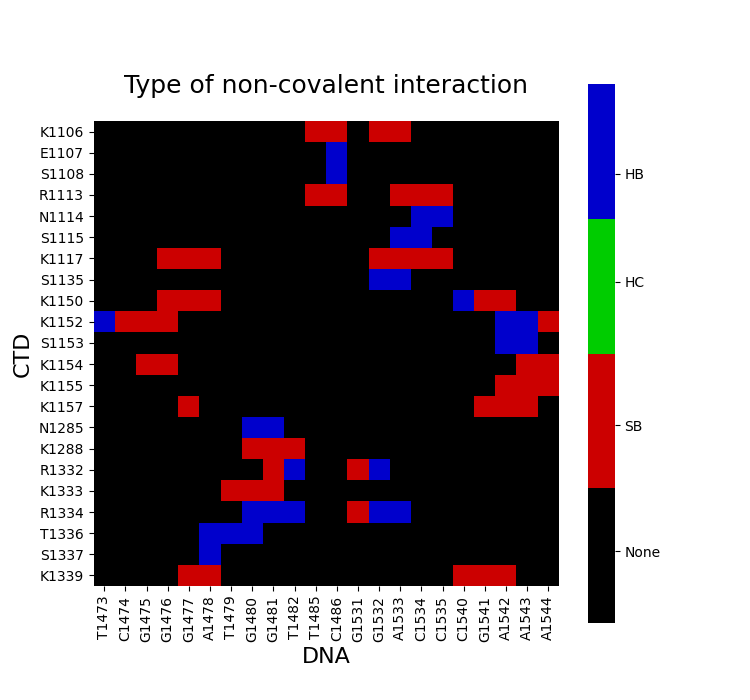

In [147]:
interactionsHeatmap(df_all, 'CTD', 'DNA', df_type=df_type_all, filt='xy', filt_cutoff=5, t='auto')

(624, 269)  ->  (9, 5)


<IPython.core.display.Javascript object>


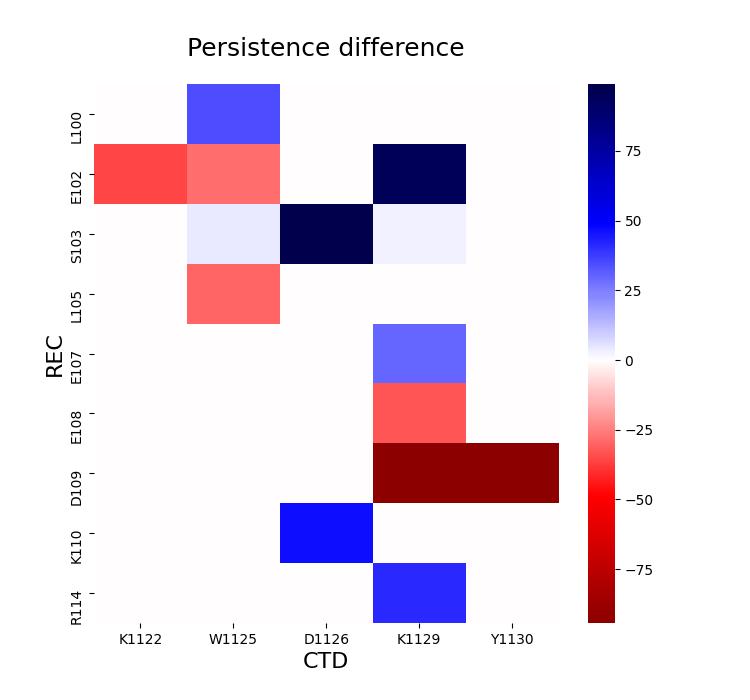

In [92]:
interactionsHeatmap(df_diff, 'REC', 'CTD', filt='xy', filt_cutoff=15, t='auto')

(126, 282)  ->  (2, 2)


<IPython.core.display.Javascript object>


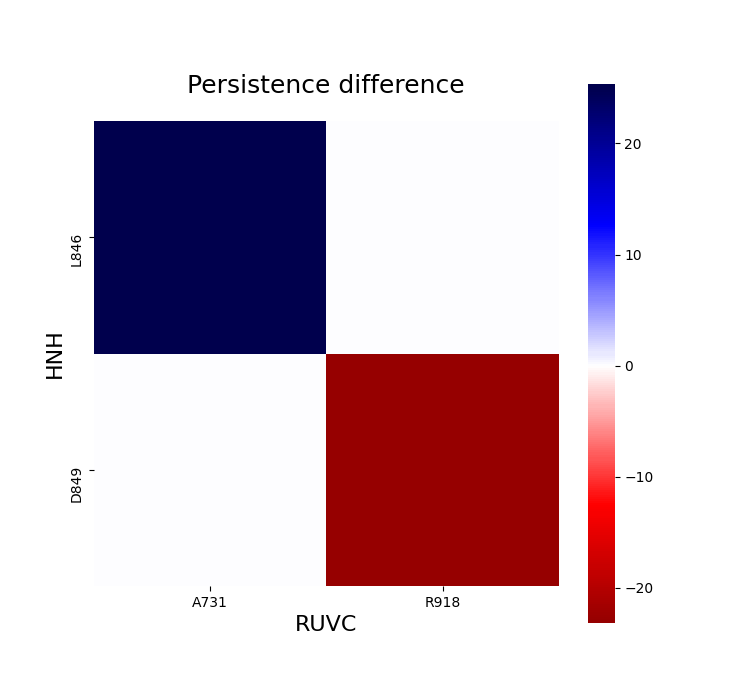

In [95]:
interactionsHeatmap(df_diff, 'HNH', 'RUVC', filt='xy', filt_cutoff=15, t='auto')

(126, 98)  ->  (7, 4)


<IPython.core.display.Javascript object>


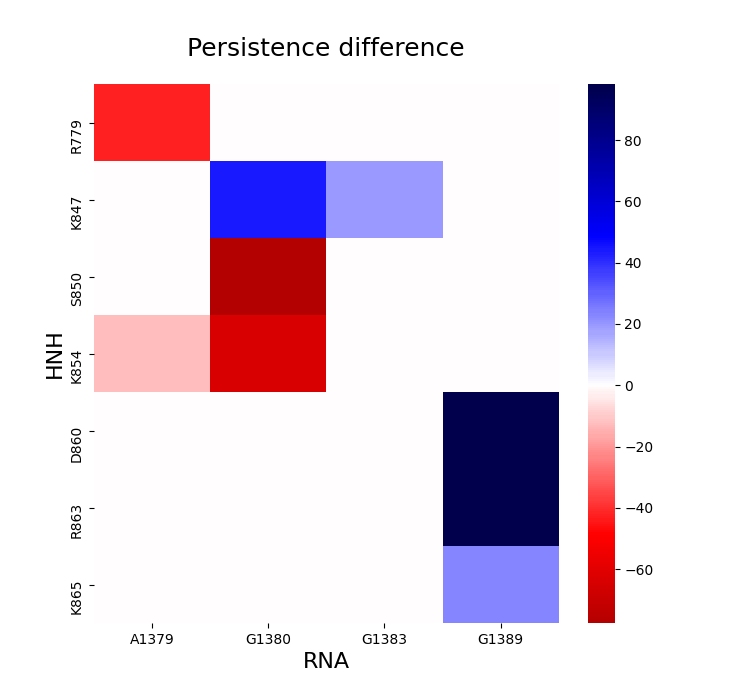

In [96]:
interactionsHeatmap(df_diff, 'HNH', 'RNA', filt='xy', filt_cutoff=15)

(624, 126)  ->  (11, 12)


<IPython.core.display.Javascript object>


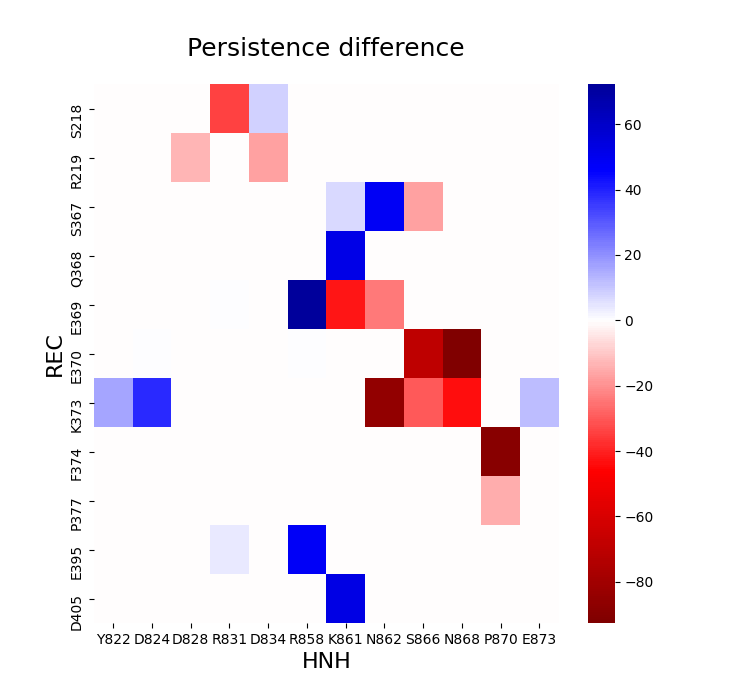

In [97]:
interactionsHeatmap(df_diff, 'REC', 'HNH', filt='xy', filt_cutoff=10)

(624, 98)  ->  (41, 32)


<IPython.core.display.Javascript object>


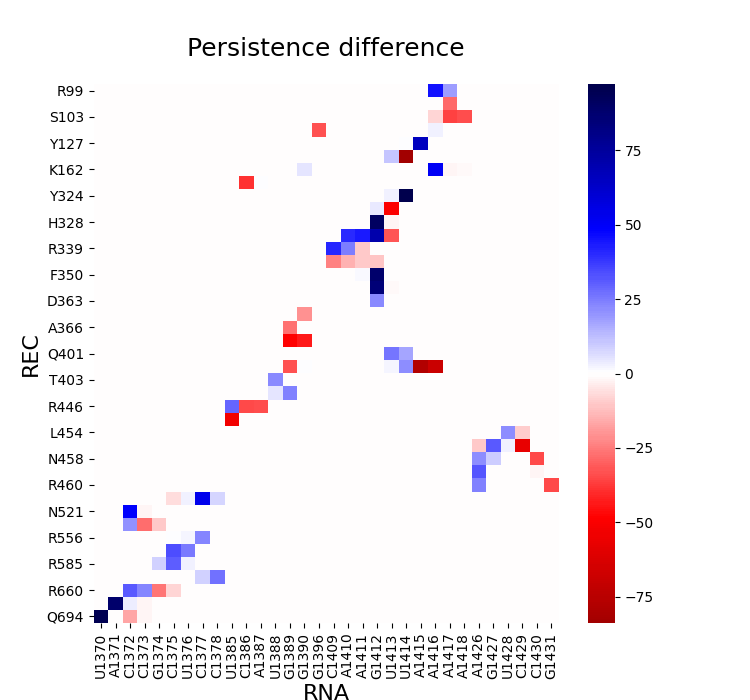

In [98]:
interactionsHeatmap(df_diff, 'REC', 'RNA', filt='xy', filt_cutoff=20)

(98, 98)  ->  (73, 73)


<IPython.core.display.Javascript object>


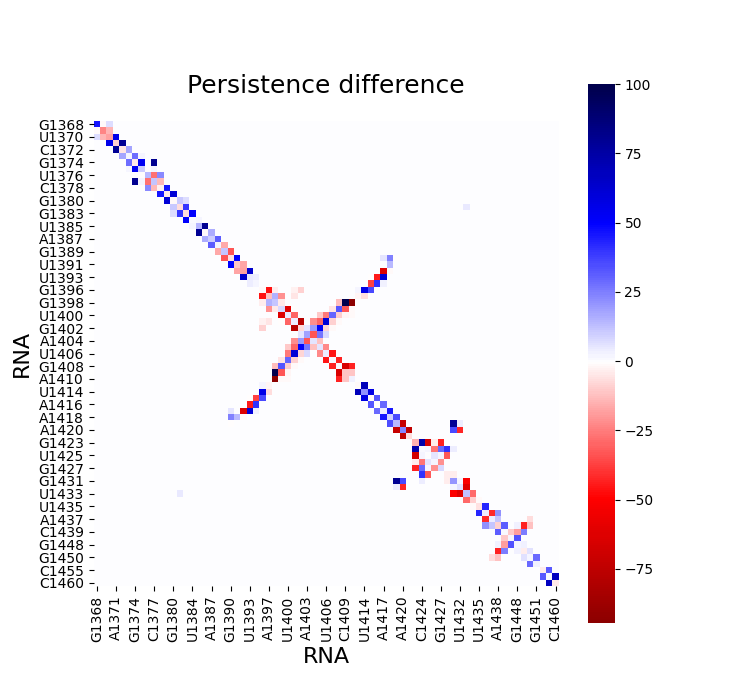

In [99]:
interactionsHeatmap(df_diff, 'RNA', 'RNA', filt='xy', filt_cutoff=20)

In [54]:
u_n.select_atoms('resid 1467').resnames[0]

'MG'

In [335]:
dir(matplotlib.patches.FancyArrowPatch)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_alias_map',
 '_bind_draw_path_function',
 '_convert_xy_units',
 '_default_contains',
 '_edge_default',
 '_get_clipping_extent_bbox',
 '_process_radius',
 '_set_alpha_for_array',
 '_set_edgecolor',
 '_set_facecolor',
 '_set_gc_clip',
 'add_callback',
 'axes',
 'contains',
 'contains_point',
 'contains_points',
 'convert_xunits',
 'convert_yunits',
 'draw',
 'fill',
 'findobj',
 'format_cursor_data',
 'get_aa',
 'get_agg_filter',
 'get_alpha',
 'get_animated',
 'get_antialiased',
 'get_arrowstyle',
 'get_capstyle',
 'get_children',
 'get_clip_box',
 'get_clip_on',
 'get_clip_path',
 'get_connectionstyle',

### Save interaction values into a pdb

Creare array con valore massimo di differenza in persistenza tra dna e nodna

In [ ]:
#u.add_TopologyAttr('tempfactors') # add empty attribute for all atoms
#protein = u.select_atoms('protein') # select protein atoms
#for residue, r_value in zip(protein.residues, R.results.rmsf):
#    residue.atoms.tempfactors = r_value
    #print(residue.atoms.tempfactors)

In [73]:
np.min(np.min(df_diff))

-100.01769911504425